<a href="https://colab.research.google.com/github/dijanaperovic/Predikcija-kategorije-proizvoda-na-osnovu-naslova/blob/main/predikcija_kategorije_proizvoda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Istrazivanje samog dataset-a

Veličina dataset-a:  (35311, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product ID       35311 non-null  int64  
 1   Product Title    35139 non-null  object 
 2   Merchant ID      35311 non-null  int64  
 3    Category Label  35267 non-null  object 
 4   _Product Code    35216 non-null  object 
 5   Number_of_Views  35297 non-null  float64
 6   Merchant Rating  35141 non-null  float64
 7    Listing Date    35252 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.2+ MB
Informacije:  None

Broj Na vrednosti po kolonama: 
product ID           0
Product Title      172
Merchant ID          0
 Category Label     44
_Product Code       95
Number_of_Views     14
Merchant Rating    170
 Listing Date       59
dtype: int64

Raspodela proizvoda po kategorijama: 
 Category Label
Fridge Freezers     5495
Washing M

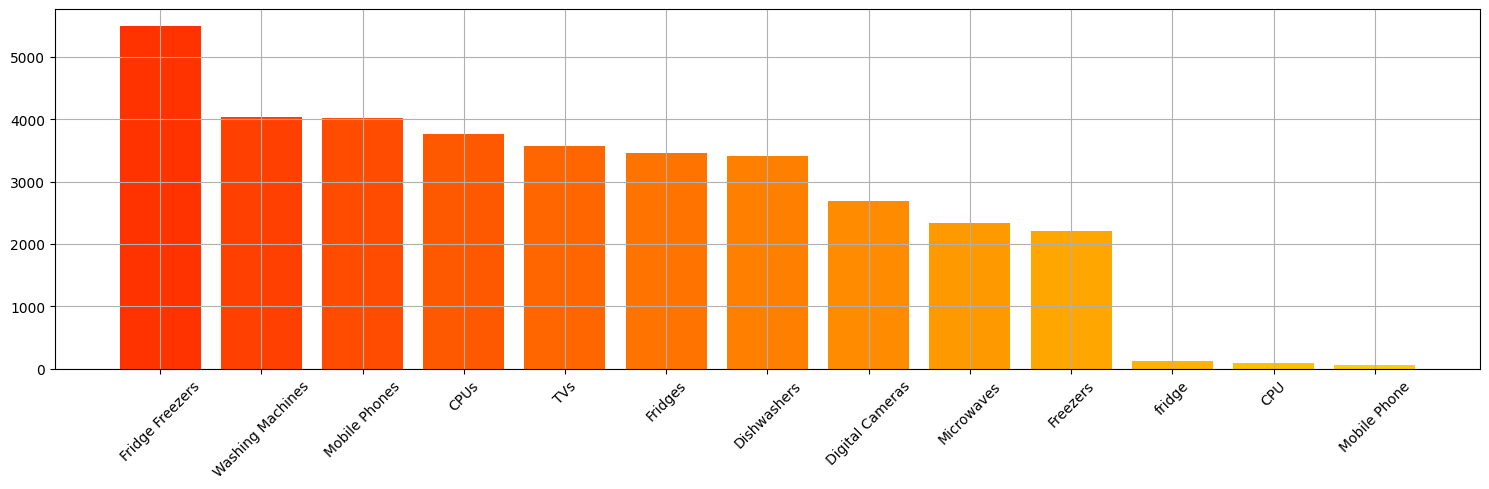

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

url = "https://raw.githubusercontent.com/dijanaperovic/Predikcija-kategorije-proizvoda-na-osnovu-naslova/refs/heads/main/data/products.csv"
df = pd.read_csv(url)
print("Veličina dataset-a: ", df.shape)
print("Informacije: ", df.info())
print("\nBroj Na vrednosti po kolonama: ")
print(df.isna().sum())

category_counts = df[' Category Label'].value_counts()
print("\nRaspodela proizvoda po kategorijama: ")
print(category_counts)

plt.figure(figsize=(15,5))
colors = plt.cm.autumn(np.linspace(0.2, 0.8, len(category_counts)))
plt.bar(category_counts.index, category_counts.values, color = colors)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
df = df.dropna()
print(df.shape)
print(df.isna().sum())
#Standardizovanje naziva kolona za lepši prikaz i lakše snalaženje
df.columns = df.columns.str.lower().str.strip().str.replace(r' ', '_', regex = True)
print(df.columns.to_list())

#Standardizacija kolone kategorije proizvoda
print("\nSve vrednosti koje se javljaju pod kategorijom proizvoda: \n", df['category_label'].unique())
df['category_label'] = df['category_label'].astype(str).str.strip().str.lower()
category_map = {
    'mobile phone': 'mobile phones',
    'cpu': 'cpus',
    'fridge': 'fridges'
}
df['category_label'] = df['category_label'].replace(category_map)


(34760, 8)
product_id         0
product_title      0
merchant_id        0
category_label     0
_product_code      0
number_of_views    0
merchant_rating    0
listing_date       0
dtype: int64
['product_id', 'product_title', 'merchant_id', 'category_label', '_product_code', 'number_of_views', 'merchant_rating', 'listing_date']

Sve vrednosti koje se javljaju pod kategorijom proizvoda: 
 ['mobile phones' 'tvs' 'cpus' 'digital cameras' 'microwaves' 'dishwashers'
 'washing machines' 'freezers' 'fridge freezers' 'fridges']


Prilikom prikazivanja svih kategorija koje se javljaju u datasetu u koloni category_label primećujem da se pojedine kategorije pojavljuju više puta, tj. razlikuju se u ispisu jednog slova, tako da u ovom delu te vrednosti standardizujem radi preciznije analize.

                 count unique  \
category_label                  
cpus              3792   3015   
digital cameras   2661   2381   
dishwashers       3374   3017   
freezers          2182   1887   
fridge freezers   5424   4772   
fridges           3524   3162   
microwaves        2307   2079   
mobile phones     4023   3636   
tvs               3502   3241   
washing machines  3971   3364   

                                                                top freq  
category_label                                                            
cpus              hp intel xeon quad core e5506 2.13ghz fio kit ...   13  
digital cameras                canon ixus 185 digital camera silver    4  
dishwashers                    built in fully integrated dishwasher   35  
freezers                                    frost free tall freezer    8  
fridge freezers                           frost free fridge freezer   34  
fridges                                      built in larder fridge    9  
mic

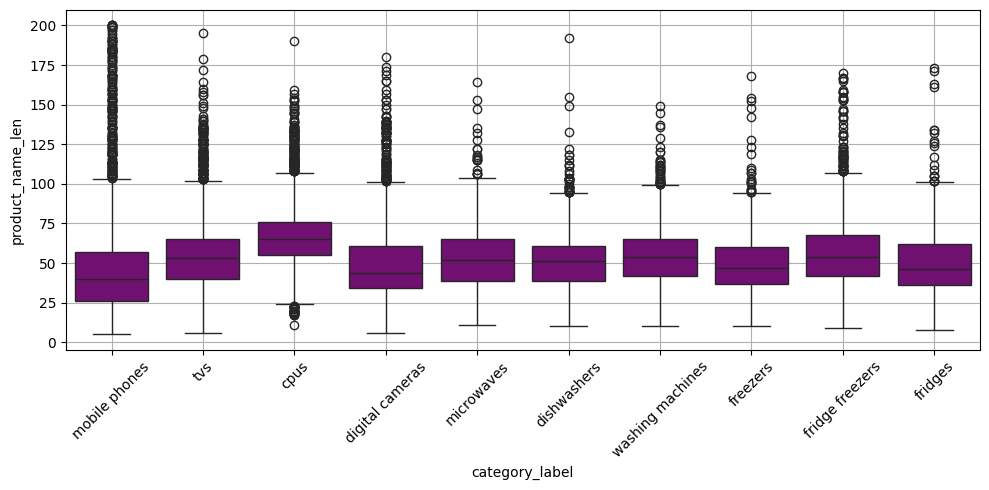

In [32]:
#Ispitivanje koje sve karakteristike pomažu u predikciji same kategorije proizvoda
print(df.groupby('category_label', observed=False)['product_title'].describe())

#Pravljenje nekih novih karakteristika koje mogu biti od značaja
df['product_name_len'] = df['product_title'].astype(str).str.len()
print(df['product_name_len'].describe())
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='category_label', y='product_name_len', color='purple')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

📱 Mobilni telefoni i digitalne kamere imaju nešto kraća imena u proseku (medijana niža).
→ To ima smisla jer su njihovi nazivi često kratki: „Samsung Galaxy A13“...

🧊 Frižideri, zamrzivači, i veš mašine imaju duže nazive u proseku.
→ Ove kategorije često uključuju više tehničkih detalja u imenu:
„LG Fridge Freezer No Frost 300L Silver“ itd.

💻 CPU i TV imaju dosta raspona — i kraće i duže nazive, ali medijana im je slična.

Tako da dužina imena samog proizvoda generalno daje slab signal ali stvaran signal o kategoriji kojoj on pripada. Na primer kraći naziv može da bude signal da se radi o proizvodu za domaćinstvo, a kraći o elektronici. Medjutim ima dosta preklapanja i nisu to neke sada drastične razlike medjutim može pomoći u maloj meri modelu pri odlučivanju.

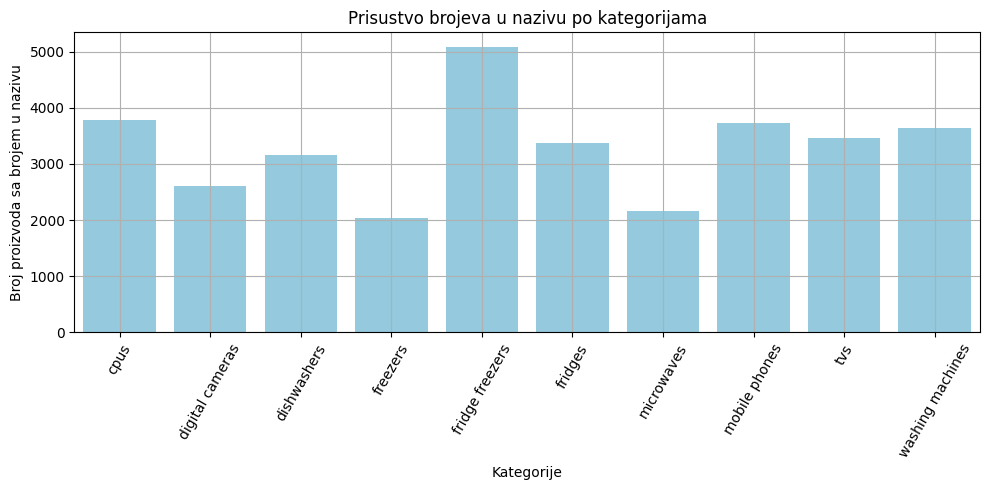

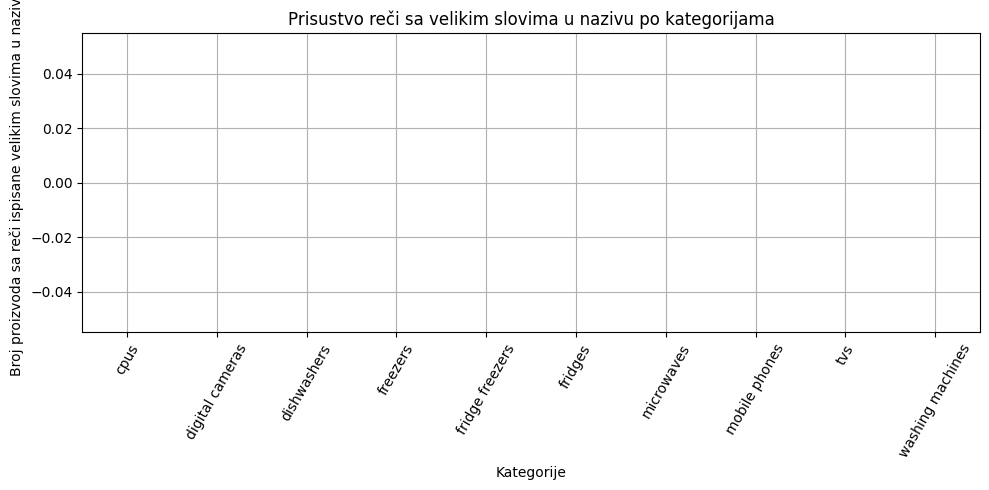

In [49]:
df['number_in_name'] = df['product_title'].apply(lambda x: int(any(ch.isdigit() for ch in x)))

numbers_per_category = df.groupby('category_label')['number_in_name'].sum().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(data=numbers_per_category, x='category_label', y='number_in_name', color='skyblue')
plt.title("Prisustvo brojeva u nazivu po kategorijama")
plt.grid(True)
plt.xlabel("Kategorije")
plt.ylabel("Broj proizvoda sa brojem u nazivu")
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

df['has_upper_word'] = df['product_title'].apply(lambda x: int(any(word.isupper() for word in x.split())))
upperwords_per_category = df.groupby('category_label')['has_upper_word'].sum().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(data=upperwords_per_category, x='category_label', y='has_upper_word', color='blue')
plt.title("Prisustvo reči sa velikim slovima u nazivu po kategorijama")
plt.grid(True)
plt.xlabel("Kategorije")
plt.ylabel("Broj proizvoda sa reči ispisane velikim slovima u nazivu")
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()



Ovde vidimo da prisustvo broja u nazivu proizvoda može pomoći pri predikciji kategorije jer postoji veća razlika u broju proizvoda medju kategorijama gde je broj u nazivu prisutan. Kod mobilnih telefona, televizora, veš mašina kao i kategorije frižider-zamrivača ove vrednosti su veoma visoke. Za razliku kod zamrzivača i digitalnih kamera. Nema proizvoda kod kojih u imenu se pojavljuje reč/reči napisane velikim slovima. Tako da nam ta karakteristika nije od koristi.

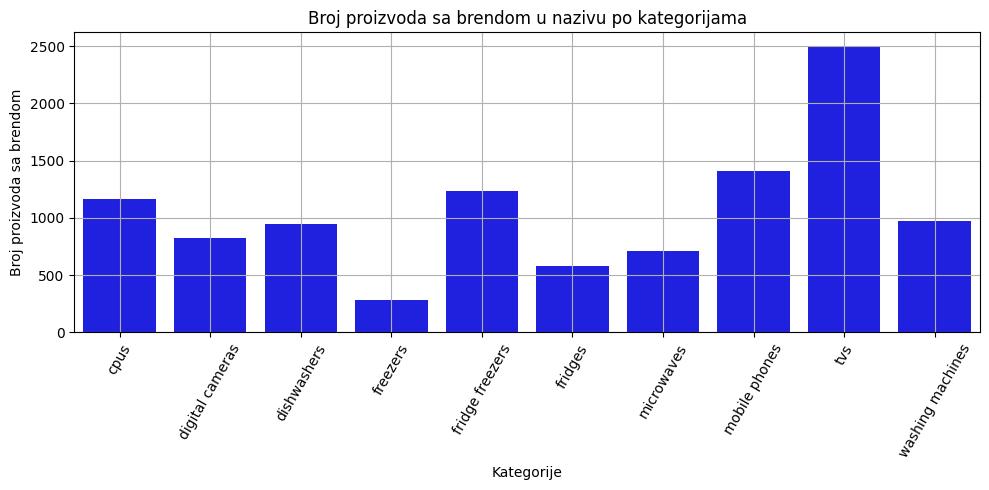

In [51]:
brands_list = [
    'iPhone', 'Samsung', 'Sony', 'Philips', 'Bosch',
    'LG', 'Panasonic', 'Apple', 'Dell', 'HP', 'Lenovo', 'Whirlpool'
]
df['has_brand'] = df['product_title'].apply(lambda x: int(any(brand.lower() in x.lower() for brand in brands_list)))
brand_per_category = df.groupby('category_label')['has_brand'].sum().reset_index()
plt.figure(figsize=(10,5))
sns.barplot(data=brand_per_category, x='category_label', y='has_brand', color='blue')
plt.title("Broj proizvoda sa brendom u nazivu po kategorijama")
plt.xlabel("Kategorije")
plt.ylabel("Broj proizvoda sa brendom")
plt.xticks(rotation=60)
plt.grid(True)
plt.tight_layout()
plt.show()

Ova karakteristika može pomoći modelu da preciznije klasifikuje proizvode. Njena vrednost raste kada se kombinuje sa drugim karakteristikama poput broja reči ili prisustva brojeva. Tako da nju možemo dodati prilikom treniranja kako bi pomogla modelu pri predikciji.Brendovi često direktno ukazuju na kategoriju (npr. "iPhone" → "mobile phones").

In [55]:
print(df.columns.to_list())
print(df['has_brand'].head(10))

['product_id', 'product_title', 'merchant_id', 'category_label', '_product_code', 'number_of_views', 'merchant_rating', 'listing_date', 'product_name_len', 'number_in_name', 'has_upper_word', 'has_brand']
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: has_brand, dtype: int64


In [56]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer


X = df[["product_title", "product_name_len", "number_in_name", "has_brand"]]
y = df["category_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

preprocessor = ColumnTransformer(
    transformers=[("title", TfidfVectorizer(), "product_title"),
                  ("lenght", MinMaxScaler(), ["product_name_len"]),
                  ("number", MinMaxScaler(), ["number_in_name"]),
                  ("brand", MinMaxScaler(), ["has_brand"])]
)

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": LinearSVC()
}

for name,model in models.items():
  print(f"\n 🔹 {model}")
  pipeline = Pipeline([
      ("preprocessing", preprocessor ),
      ("classifier", model)])
  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)
  print(classification_report(y_test, y_pred))


 🔹 LogisticRegression(max_iter=1000)
                  precision    recall  f1-score   support

            cpus       1.00      1.00      1.00       758
 digital cameras       1.00      0.99      1.00       532
     dishwashers       0.90      0.97      0.93       675
        freezers       0.99      0.91      0.95       436
 fridge freezers       0.96      0.93      0.94      1085
         fridges       0.90      0.91      0.90       705
      microwaves       1.00      0.95      0.97       461
   mobile phones       0.97      0.99      0.98       805
             tvs       0.97      0.99      0.98       701
washing machines       0.94      0.95      0.95       794

        accuracy                           0.96      6952
       macro avg       0.96      0.96      0.96      6952
    weighted avg       0.96      0.96      0.96      6952


 🔹 MultinomialNB()
                  precision    recall  f1-score   support

            cpus       0.99      1.00      0.99       758
 digital c

📊 Analiza rezultata modela

U okviru rada testirano je više klasifikacionih algoritama sa ciljem predviđanja kategorije proizvoda na osnovu dostupnih tekstualnih i dodatnih karakteristika. Upoređivani su modeli: Logistic Regression, Multinomial Naive Bayes, Decision Tree Classifier, Random Forest Classifier i Linear Support Vector Classifier (LinearSVC).

Dobijeni rezultati pokazuju da svi modeli ostvaruju visoku tačnost, veću od 90%. Najbolje performanse postigli su ✅ LinearSVC, RandomForestClassifier i LogisticRegression, dok je MultinomialNB ostvario nešto slabije rezultate zbog ograničene sposobnosti u prepoznavanju kompleksnijih obrazaca u tekstu. Decision Tree model je postigao sličnu tačnost kao Logistic Regression, što potvrđuje njegovu stabilnost, ali i nešto manju generalizaciju u odnosu na kompleksnije modele.

💡 Na osnovu analize metrika preciznosti, odziva i f1-score vrednosti, zaključuje se da su LinearSVC i RandomForestClassifier najpouzdaniji za ovu vrstu problema jer ostvaruju uravnotežene rezultate kroz sve klase proizvoda.

Dodatno, uključivanje karakteristike ⚙️ brenda proizvoda pokazalo se korisnim jer doprinosi boljem razlikovanju sličnih artikala unutar iste kategorije i pozitivno utiče na ukupne performanse modela. Jer gore vidimo da je kod kategorije frižidera najmanja prisutnost brenda u nazivu proizvoda i ova kategorija se kod svih modela najlošije pokazala za predikciju. Dok sa druge strane mobilni telefoni i televizori kod kojih je dosta proizvoda sa brendom u nazivu veoma dobro prepoznati od strane svih modela. Takodje i dužina samog naziva i prisustva broja u istom su bile veoma korisne karakteristike.